In [2]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf

Question 1

Text(0.5, 1.0, 'Points Set')

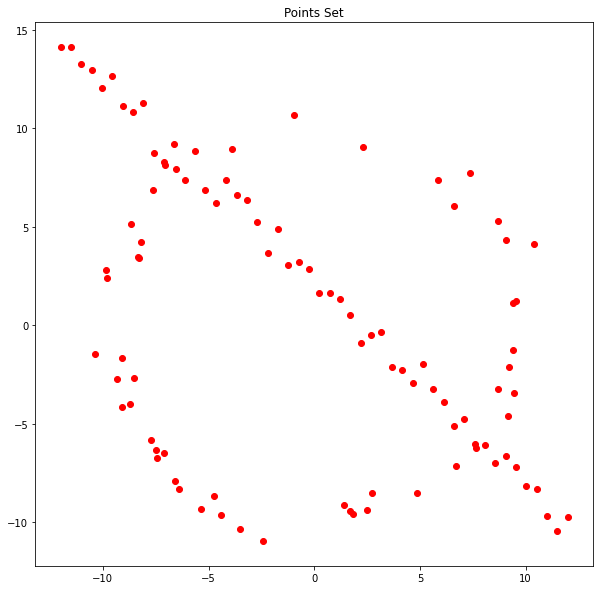

In [61]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n, 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(X_circ[:,0], X_circ[:,1], 'ro')
ax.plot(X_line[:,0], X_line[:,1], 'ro')

ax.set_title("Points Set")

In [62]:
def estimate_circle(x1, x2, x3):
    denominator_1 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
    denominator_2 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )

    if denominator_1 != 0 and denominator_2 != 0:
        a = 0.5 * ( (x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) ) / denominator_1
        b = 0.5 * ( (x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) ) / denominator_2
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]

        r = np.sqrt(a**2 + b**2 - c)
    else:
        a,b,r = None, None, None

    return a, b, r

def get_circle(x1, x2, x3):
    a, b, r = estimate_circle(x1, x2, x3)

    circle = plt.Circle((a, b), r, color='b', fill=False)

    return circle

def get_inlier_count(a, b, r, X, t):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )

        if distance < t:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return count, best_fit_inliers

def RANSAC_circle(X):
    # Parameter for the RANSAC algorithm 
    s = 3
    t = 1.96
    d = 50
    N = 35

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(s):
            hold = X[np.random.randint(0, 100), :]
            
            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, 100), :]
                
                x.append(hold)
            else:
                x.append(hold)
        
        a, b, r = estimate_circle(x[0], x[1], x[2])

        if a == None:
            continue

        count, inliers = get_inlier_count(a, b, r, X, t)

        if count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count
    
    if best_inlier_count < d:
        print("The RANSAC algorithm did not find a suitable model")
        return None, None, None, None

    xc,yc,r,_ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers

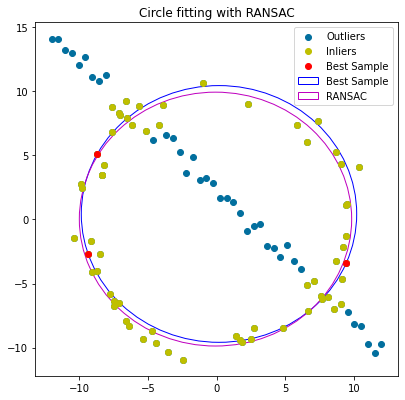

In [72]:
ransac_circle, best_fit_circle, x, inliers = RANSAC_circle(X)

if ransac_circle != None:
    fig, ax = plt.subplots(1, 1, figsize=(6.5,6.5))
    ax.scatter(X_circ[:,0], X_circ[:,1], color="#026f9e")
    ax.scatter(X_line[:,0], X_line[:,1], color="#026f9e", label="Outliers")

    if type(inliers) != type(None):
        for point in inliers:
            if np.array_equal(point, inliers[-1]):
                ax.plot(point[0], point[1], 'yo', label="Inliers")
            else:
                ax.plot(point[0], point[1], 'yo')


    for point in x:
        if np.array_equal(point, x[-1]):
            ax.plot(point[0], point[1], 'ro', label="Best Sample")
        else:
            ax.plot(point[0], point[1], 'ro')

    ax.add_patch(best_fit_circle)
    ax.add_patch(ransac_circle)
    ax.set_title("Circle fitting with RANSAC")
    ax.legend(loc="upper right")


Question 2


In [6]:
def click_event(event, x, y, flags, params):
    global coordinates
    global count
    global first_image

    if event == cv.EVENT_LBUTTONDOWN:
        coordinates.append([x, y])
        count += 1

        first_image = cv.circle(first_image, (x,y), 2, (0, 0, 1), -1)
        cv.imshow("Image", first_image)        
    
    if count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)


(-0.5, 603.5, 452.5, -0.5)

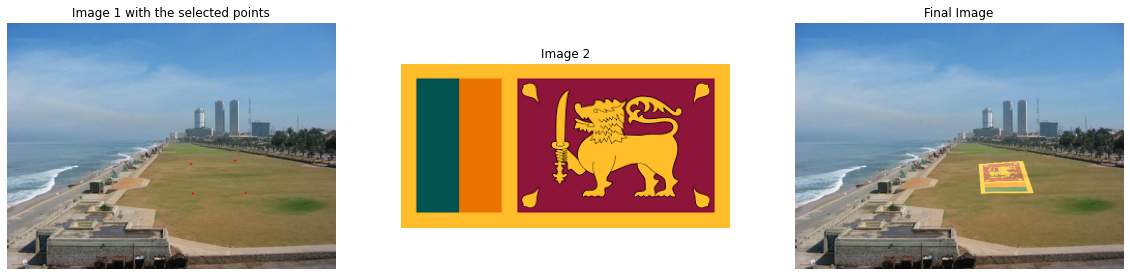

In [7]:
image_1 = cv.imread(r"Images/galle_face.jpg")
image_2 = cv.imread(r"Images/sri_lanka_flag.png")

info = np.iinfo(image_1.dtype) 
image_1 = image_1.astype(np.float64) / info.max

info = np.iinfo(image_2.dtype) 
image_2 = image_2.astype(np.float64) / info.max

first_image = np.copy(image_1)

coordinates = []
count = 0

cv.imshow("Image", image_1)

cv.setMouseCallback("Image", click_event)
cv.waitKey(0)

if len(coordinates) < 4:
    print("You have selected less than 4 points. Please select 4 points")

cv.destroyAllWindows()

# Input parameters
X = np.array([
    [0, 0, 1],
    [image_2.shape[1], 0, 1],
    [image_2.shape[1], image_2.shape[0], 1],
    [0, image_2.shape[0], 1]
]).T

Y = np.array([
    [coordinates[0][0], coordinates[0][1], 1],
    [coordinates[1][0], coordinates[1][1], 1],
    [coordinates[2][0], coordinates[2][1], 1],
    [coordinates[3][0], coordinates[3][1], 1],
]).T

O = np.array([
    [0],
    [0],
    [0]
])

A = []

for i in range(4):
    A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
    A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

A = np.array(A).squeeze().astype(np.float64)

eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
H = eigen_vectors[:, np.argmin(eigen_values)]
H = H.reshape(3, -1)

t_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

beta = 0.5
blended_img = cv.addWeighted(image_1, 1, t_image_2, beta, 0.0)
blended_img[blended_img > 1] = 1

first_image_rgb = cv.cvtColor(first_image.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
blended_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(first_image_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(blended_img_rgb)

ax[0].set_title("Image 1 with the selected points")
ax[1].set_title("Image 2")
ax[2].set_title("Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

Question 3


(-0.5, 1599.5, 639.5, -0.5)

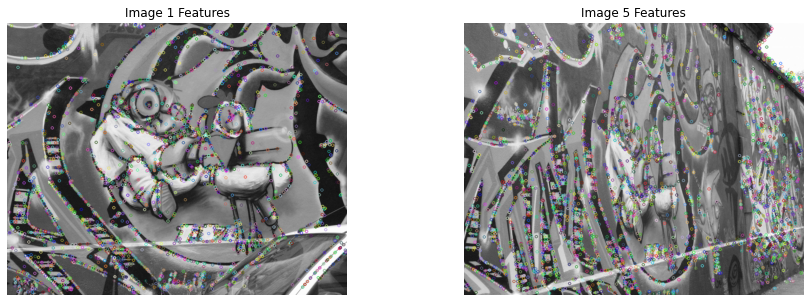

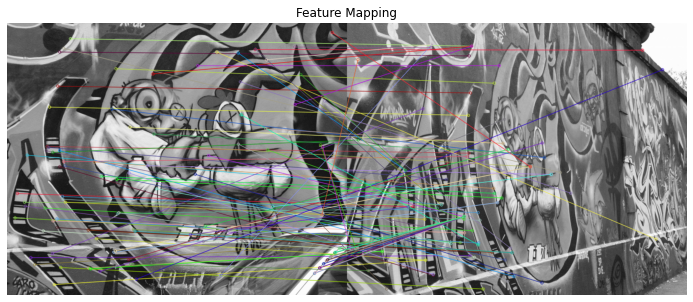

In [8]:
img1 = cv.imread(r"Images/graf/img1.ppm")
img5 = cv.imread(r"Images/graf/img5.ppm")

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09,edgeThreshold = 25,sigma =1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img5_gray, None)  

keypoints_img_1 = np.zeros(img1_gray.shape)
keypoints_img_5 = np.zeros(img5_gray.shape)

keypoints_img_1 = cv.drawKeypoints(img1_gray, keypoints_1, keypoints_img_1)
keypoints_img_5 = cv.drawKeypoints(img5_gray, keypoints_2, keypoints_img_5)

bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])

matches_img = np.zeros(img1_gray.shape)
matches_img_fifty = np.zeros(img1_gray.shape)

matches_img = cv.drawMatchesKnn(img1_gray, keypoints_1, img5_gray, keypoints_2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

good_matches = np.squeeze(np.array(good_matches))

img1_gray = img1_gray.astype(np.float64) / 255
img5_gray = img5_gray.astype(np.float64) / 255

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 5))

ax[0].imshow(keypoints_img_1)
ax[1].imshow(keypoints_img_5)
ax2.imshow(matches_img)

ax[0].set_title("Image 1 Features")
ax[1].set_title("Image 5 Features")
ax2.set_title("Feature Mapping")

ax[0].axis("off")
ax[1].axis("off")
ax2.axis("off")


In [46]:
def get_homography(X, Y):
    O = np.array([
        [0],
        [0],
        [0]
    ])

    A = []

    for i in range(4):
        A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
        A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

    A = np.array(A).squeeze().astype(np.float64)

    eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
    H = eigen_vectors[:, np.argmin(eigen_values)]
    H = H.reshape(3, -1)

    return H

def get_inlier_count(X_full, Y_full, H, t, X_inliers, Y_inliers):
    count = 0

    t_X_full = H @ X_full
    t_X_full = t_X_full / t_X_full[2,:]

    error = np.sqrt(np.sum(np.square(t_X_full - Y_full), axis=0))

    inlier_indices = np.where(error <= t)[0]

    X_inliers = np.concatenate((X_inliers, X_full[:,inlier_indices]), axis=1)
    Y_inliers = np.concatenate((Y_inliers, Y_full[:,inlier_indices]), axis=1)

    count = inlier_indices.shape[0]

    return count, X_inliers, Y_inliers

def get_sift_features(img1_path, img2_path):
    img1 = cv.imread(img1_path)
    img5 = cv.imread(img2_path)

    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray, None) 
    keypoints_2, descriptors_2 = sift.detectAndCompute(img5_gray, None)  

    keypoints_img_1 = np.zeros(img1_gray.shape)
    keypoints_img_5 = np.zeros(img5_gray.shape)

    keypoints_img_1 = cv.drawKeypoints(img1_gray, keypoints_1, keypoints_img_1)
    keypoints_img_5 = cv.drawKeypoints(img5_gray, keypoints_2, keypoints_img_5)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)

    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])

    matches_img = np.zeros(img1_gray.shape)
    matches_img_fifty = np.zeros(img1_gray.shape)

    matches_img = cv.drawMatchesKnn(img1_gray, keypoints_1, img5_gray, keypoints_2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    good_matches = np.squeeze(np.array(good_matches))

    return good_matches, keypoints_1, keypoints_2
    

def RANSAC(img1_path, img2_path, t, d, N):
    # Parameter for the RANSAC algorithm 
    s = 4

    best_fit_homography = None
    best_inlier_count = 0
    best_fit_X_inliers = None
    best_fit_Y_inliers = None
    count_db = []

    matches, kp1, kp2 = get_sift_features(img1_path, img2_path)

    X_full = np.zeros((len(matches), 3))
    Y_full = np.zeros((len(matches), 3))

    for i, match in enumerate(matches):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt

        X_full[i,:] = np.array([p1[0], p1[1], 1])
        Y_full[i,:] = np.array([p2[0], p2[1], 1])
    
    X_full = X_full.T
    Y_full = Y_full.T

    for _ in range(N):
        x = []

        for i in range(s):
            hold_idx = np.random.randint(0, len(matches))
            
            if len(x) == 0:
                x.append(hold_idx)
            elif hold_idx == x[-1]:                
                while hold_idx == x[-1]:
                    hold_idx = np.random.randint(0, len(matches))
                
                x.append(hold_idx)
            else:
                x.append(hold_idx)
        
        X = np.zeros((4,3))
        Y = np.zeros((4,3))

        for i, idx in enumerate(x):
            match = matches[idx]

            p1 = kp1[match.queryIdx].pt
            p2 = kp2[match.trainIdx].pt

            X[i,:] = np.array([p1[0], p1[1], 1])
            Y[i,:] = np.array([p2[0], p2[1], 1])

        X = X.T
        Y = Y.T

        X_inliers = np.zeros((3, 1))
        Y_inliers = np.zeros((3, 1))
    
        H = get_homography(X, Y)        

        count, X_inliers, Y_inliers = get_inlier_count(X_full, Y_full, H, t, X_inliers, Y_inliers)

        X_inliers = np.delete(X_inliers, 0, axis=1)
        Y_inliers = np.delete(Y_inliers, 0, axis=1)

        count_db.append(count)

        if count > best_inlier_count:
            best_fit_homography = H
            best_inlier_count = count
            best_fit_X_inliers = X_inliers
            best_fit_Y_inliers = Y_inliers
    
    return best_fit_homography, best_inlier_count, count_db, best_fit_X_inliers, best_fit_Y_inliers

Text(0.5, 1.0, 'Final Stitched Image')

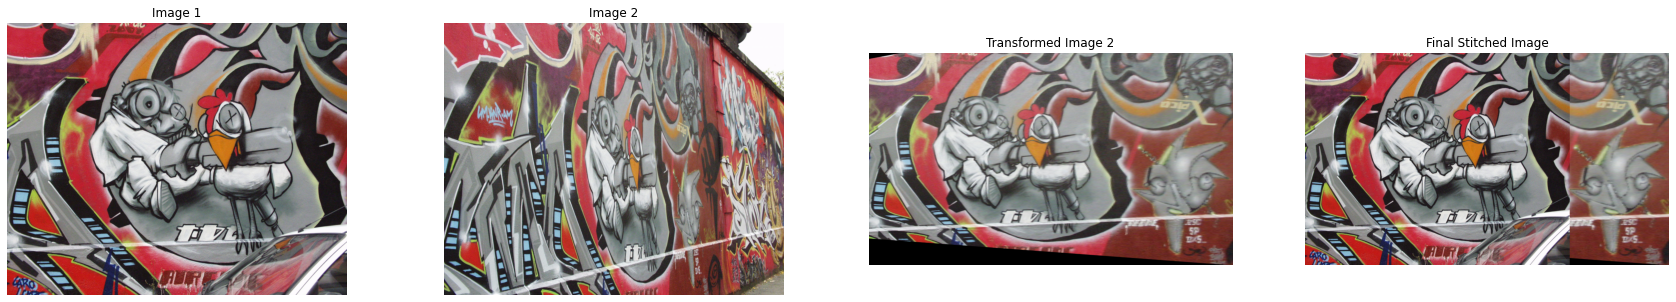

In [57]:
with open("Images/graf/H1to5p", "r") as txt_file:
    actual_H = txt_file.read()
    actual_H = actual_H.split('\n')
    actual_H.pop()

    for i in range(len(actual_H)):
        actual_H[i] = list(map(float, actual_H[i].strip().split()))
    
    actual_H = np.array(actual_H)

path = r"Images/graf/"
H_db_inv = []

for i in range(1, 5):
    img1_path = path + "img" + str(i) + ".ppm"
    img2_path = path + "img" + str(i+1) + ".ppm"

    H, count, count_db, best_fit_X_inliers, best_fit_Y_inliers = RANSAC(img1_path, img2_path, 1, 20, 10000)

    H_db_inv.append(np.linalg.inv(H))

H5to1 = H_db_inv[-1]

for i in range(len(H_db_inv)-2, -1, -1):
    H5to1 = H_db_inv[i] @ H5to1

final_img = cv.imread("Images/graf/img5.ppm")
final_img = cv.warpPerspective(final_img, H5to1, dsize=(1100, 640))

t_img_5 = np.copy(final_img)
final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

fig, ax = plt.subplots(1, 4, figsize=(30, 5))

ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(t_img_5, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

ax[0].set_title("Image 1")
ax[1].set_title("Image 2")
ax[2].set_title("Transformed Image 2")
ax[3].set_title("Final Stitched Image")

(-0.5, 1099.5, 639.5, -0.5)

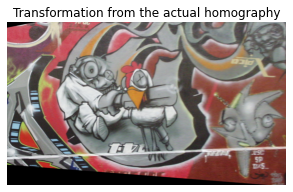

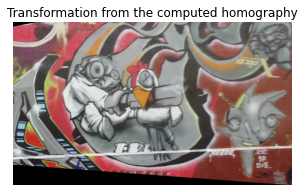

In [74]:
actual_transformed_img = cv.warpPerspective(img5, np.linalg.inv(actual_H), dsize=(1100, 640))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(cv.cvtColor(actual_transformed_img, cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(t_img_5, cv.COLOR_BGR2RGB))

ax.set_title("Transformation from the actual homography")
ax2.set_title("Transformation from the computed homography")

ax.axis('off')
ax2.axis('off')

(-0.5, 1099.5, 639.5, -0.5)

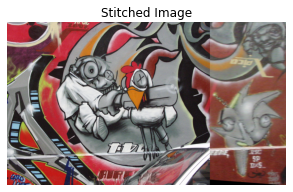

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))
ax.set_title("Stitched Image")
ax.axis('off')

Computed Homography:
[[ 8.27212794e-11  6.71870717e-12  3.03233982e-08]
 [ 2.90487388e-11  1.55010572e-10 -2.96662588e-09]
 [ 6.40661394e-14 -7.10375518e-15  1.35034033e-10]]
Actual Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


(-0.5, 1099.5, 1099.5, -0.5)

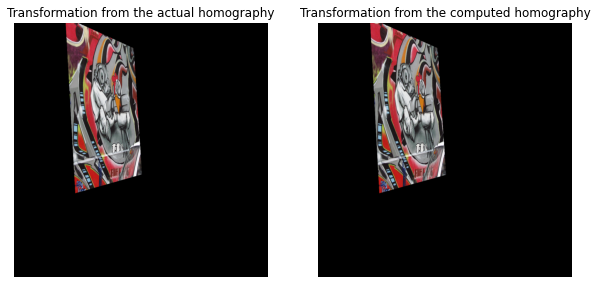

In [50]:
H1to5 = np.linalg.inv(H5to1)

print(f"Computed Homography:\n{H1to5}")
print(f"Actual Homography:\n{actual_H}")

actual_transformed_img = cv.warpPerspective(img1, actual_H, dsize=(1100, 1100))
alt = cv.warpPerspective(img1, H1to5, dsize=(1100, 1100))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(cv.cvtColor(actual_transformed_img, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(alt, cv.COLOR_BGR2RGB))

ax[0].set_title("Transformation from the actual homography")
ax[1].set_title("Transformation from the computed homography")

ax[0].axis('off')
ax[1].axis('off')

In [53]:
computed =  H1to5 * actual_H[0,0] / H1to5[0,0]

error = np.sum(np.square(computed - actual_H))
print(error)

62.786020638647585
